## Dataset

### Dataset Loading and Preprocessing

This section handles the loading and initial preparation of the MNIST dataset. MNIST contains 28x28 pixel grayscale images of handwritten digits (0-9).

**Key Operations:**

1.  **Data Loading (`load_mnist_images`, `load_mnist_labels`):**
    *   These functions read the MNIST dataset from its specific binary file format.
    *   Image data is reshaped to `(num_images, rows, cols)`.

2.  **One-Hot Encoding Labels:**
    *   For multi-class classification with a softmax output and categorical cross-entropy loss, integer labels (e.g., digit `5`) are converted into a one-hot vector format (e.g., `[0,0,0,0,0,1,0,0,0,0]` for 10 classes).
    *   This represents the true label as a probability distribution where the correct class has a probability of 1.

In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        # Leggi intestazione: magic number, numero immagini, righe, colonne
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        # Leggi tutti i pixel e convertili in array numpy
        images = np.frombuffer(f.read(), dtype=np.uint8)
        # Ridimensiona l'array in (num_images, rows, cols)
        images = images.reshape((num_images, rows, cols))
    return images

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

#-------------- Data Extraction ---------------------------
train_images = load_mnist_images('MNIST/train-images-idx3-ubyte')
train_labels = load_mnist_labels('MNIST/train-labels-idx1-ubyte')

test_images = load_mnist_images('MNIST/t10k-images.idx3-ubyte')
test_labels = load_mnist_labels('MNIST/t10k-labels.idx1-ubyte')

#--------------- Train data manipulation ------------------
print(train_images.shape)  # (60000, 28, 28)
print(train_labels.shape)  # (60000,)

one_hot_labels = np.zeros(train_labels.shape[0]*10).reshape((train_labels.shape[0]),10)
for i in range(len(train_labels)):
    one_hot_labels[i][train_labels[i]]=1
train_labels = one_hot_labels

print(train_labels.shape) # (60000,10)

#--------------- Test data manipulation -------------------
print(test_images.shape)  # (10000, 28, 28)
print(test_labels.shape)  # (10000,)

one_hot_labels = np.zeros(test_labels.shape[0]*10).reshape((test_labels.shape[0]),10)
for i in range(len(test_labels)):
    one_hot_labels[i][test_labels[i]]=1
test_labels = one_hot_labels

print(test_labels.shape) # (10000,10)

(60000, 28, 28)
(60000,)
(60000, 10)
(10000, 28, 28)
(10000,)
(10000, 10)


## PyTorch CNN Model Architecture

A Convolutional Neural Network (CNN) is defined using PyTorch's `nn.Module` to serve as a reference and source of pre-trained weights.

**Architecture (defined as `SimpleCNN` class):**

1.  **Conv1 + ReLU1:** `nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=2, padding=0)`
    *   Input: `(B, 1, 28, 28)`
    *   Output dimension: $O = \lfloor \frac{(I - K + 2P)}{S} \rfloor + 1 = \lfloor \frac{(28 - 2 + 0)}{2} \rfloor + 1 = 14$
    *   Output: `(B, 32, 14, 14)`

2.  **Conv2 + ReLU2:** `nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=1)`
    *   Input: `(B, 32, 14, 14)`
    *   Padded input dimension: $14 + 2*1 = 16$
    *   Output dimension: $O = \lfloor \frac{(16 - 2 + 0)}{2} \rfloor + 1 = 8$
    *   Output: `(B, 64, 8, 8)`

3.  **Conv3 + ReLU3:** `nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=0)`
    *   Input: `(B, 64, 8, 8)`
    *   Output dimension: $O = \lfloor \frac{(8 - 2 + 0)}{2} \rfloor + 1 = 4$
    *   Output: `(B, 128, 4, 4)`

4.  **Flatten:** `nn.Flatten()`
    *   Input: `(B, 128, 4, 4)`
    *   Output: `(B, 128 * 4 * 4)` which is `(B, 2048)`

5.  **FC1 + ReLU4:** `nn.Linear(in_features=2048, out_features=250)`
    *   Input: `(B, 2048)`
    *   Operation: $Y = XW^T + b$
    *   Output: `(B, 250)`

6.  **FC2:** `nn.Linear(in_features=250, out_features=10)` (Output layer)
    *   Input: `(B, 250)`
    *   Output: `(B, 10)` (logits for 10 classes)

<figure style="text-align:center;">
    <img src="cnn.png", style="border-radius:20px;", height=300>
    <figcaption>CNN Architecture (B: Batch size)</figcaption>
</figure>

### Model and Dataset Declaration with Training

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
from tqdm import tqdm

# 1.------------------ CNN declaration -------------------

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        # --------- Convolutional Layers ------------
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=2, padding=0)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=0)
        self.relu3 = nn.ReLU()
        # ---------- Flatten to become MLP's input -----------
        self.flatten = nn.Flatten()
        fc_input_size = 128 * 4 * 4
        # ---------- Multi Layer Perceptron ---------------
        # Only one hidden layer for classification
        self.fc1 = nn.Linear(in_features=fc_input_size, out_features=250)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=250, out_features=num_classes)

    def forward(self, x):
        # First convolution: from 1x1x28x28 to 1x32x14x14
        x = self.conv1(x)
        x = self.relu1(x)
        # Second Convolution: from 1x32x14x14 to 1x64x8x8
        x = self.conv2(x)
        x = self.relu2(x)
        # Third Convolution: from 1x64x8x8 to 1x128x4x4
        x = self.conv3(x)
        x = self.relu3(x)
        # Flatten
        x = self.flatten(x)
        # MLP
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)

        return x

# # 2.------------------ CNN's Dataset declaration ----------------------

# class CNNDataset(Dataset):
#     def __init__(self, digits, labels, transform=None):
#         assert len(digits) == len(labels), "Number of digits and labels doesn't match"
#         self.digits = digits
#         self.labels = labels

#     def __len__(self):
#         return len(self.digits)

#     def __getitem__(self, idx):
#         digit = self.digits[idx]
#         label = self.labels[idx]
#         digit = digit.unsqueeze(0) # Needed operation to add the dimension of greyscale images (28,28) -> (1,28,28)
#         return digit, label

# tri = torch.from_numpy(train_images).float() / 255
# trl = torch.from_numpy(train_labels).float()
# tsi = torch.from_numpy(test_images).float() / 255
# tsl = torch.from_numpy(test_labels).float()

# train_dataset = CNNDataset(tri,trl)
# test_dataset = CNNDataset(tsi,tsl)

# batch_size = 128
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # 3.------ Training Setup ---------------

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print(f"device: {device}")

# model = SimpleCNN(num_classes=10).to(device)

# # Loss definition
# criterion = nn.CrossEntropyLoss() 

# # Optimisation definition
# learning_rate = 0.001
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# num_epochs = 5 

# # 4.------- cycle training ------

# print("\nStarting Training...")
# for epoch in range(num_epochs):

#     model.train() 

#     running_loss = 0.0
#     start_time = time.time()
#     #tqdm is module used to have a progress bar
#     progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

#     for inputs, labels in progress_bar:

#         # move data on the device
#         inputs, labels = inputs.to(device), labels.to(device)

#         # make all gradients zero to avoid learning on gradients of previous steps
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs) 
#         # loss computation
#         loss = criterion(outputs, labels)

#         # Backward pass: compute the gradients
#         loss.backward()

#         # Weights update
#         optimizer.step()

#         # Update the loss
#         running_loss += loss.item() * inputs.size(0) # multiply for batch size to obtain the correct mean

#         # Update the progress bar
#         progress_bar.set_postfix(loss=f"{loss.item():.4f}")

#     # Epochs' mean loss computation
#     epoch_loss = running_loss / len(train_loader.dataset)
#     epoch_time = time.time() - start_time

#     print(f"Epoch {epoch+1}/{num_epochs} - Tempo: {epoch_time:.2f}s - Training Loss: {epoch_loss:.4f}")

#     # --- Test evaluation (after every epoch) ---
#     model.eval()
#     test_loss = 0.0
#     correct = 0
#     total = 0

#     with torch.no_grad(): # Disable gradient computation (we don't need gradients since we don't want to update the model in this phase)
#         i=0
#         for inputs, labels in test_loader:
#             if i >= 1:
#                 continue
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item() * inputs.size(0)
#             _, predicted = torch.max(outputs.data, 1) # Obtain index with the maximum probability (it is our result)
#             _,labels = torch.max(labels,1) # same for the test labels
#             total += labels.size(0)
#             correct += (predicted==labels).sum().item()
#             i+=1

#     avg_test_loss = test_loss / len(test_loader.dataset)
#     accuracy = 100 * correct / total
#     print(f"Epoch {epoch+1}/{num_epochs} - Test Loss: {avg_test_loss:.4f} - Test Accuracy: {accuracy:.2f}%")


# print("\nTraining Complete.")
# #2m 9.4 secondi per avere un'epoca con cuda
# # save the model
# torch.save(model.state_dict(), 'simple_cnn_mnist.pth')

### Extracting Pre-trained Weights from PyTorch Model

This section loads weights from a pre-trained PyTorch model (`simple_cnn_mnist.pth`) and converts them into NumPy arrays. These NumPy weights will be used for our custom CNN implementations to ensure consistency for inference comparisons.

In [3]:
model = SimpleCNN(num_classes=10)
model.load_state_dict(torch.load('simple_cnn_mnist.pth', map_location=torch.device('cpu'),weights_only=True)) # Carica su CPU

model.eval() # good practice is to set model in evaluation when you want to extract weights

# --- Parameters Extraction ⛏️ and Numpy Conversion ---

# Weights container
numpy_weights = {}

# Move model on cpu
model.to('cpu')

print("⛏️ Weights and Bias Extraction ⛏️\n")

# Layer Conv1
# PyTorch weight shape: (out_channels, in_channels, kernel_height, kernel_width)
# NumPy expected: (in_channels, out_channels, kernel_width, kernel_height) -> (1, 32, 3, 3)
pytorch_weights_of_kernels_in_layer_1 = model.conv1.weight.data.detach().numpy()
# Transpose: (out, in, kH, kW) -> (in, out, kW, kH)
numpy_weights['k1'] = pytorch_weights_of_kernels_in_layer_1

# PyTorch bias shape: (out_channels,)
numpy_weights['b_conv1'] = model.conv1.bias.data.detach().numpy() # Shape (32,)
print(f"k1: PyTorch Shape={pytorch_weights_of_kernels_in_layer_1.shape}, NumPy Shape={numpy_weights['k1'].shape}")
print(f"b_conv1: NumPy Shape={numpy_weights['b_conv1'].shape}")

# Layer Conv2
# PyTorch weight shape: (64, 32, 3, 3)
# NumPy expected: (32, 64, 3, 3)
pytorch_weights_of_kernels_in_layer_2 = model.conv2.weight.data.detach().numpy()
numpy_weights['k2'] = pytorch_weights_of_kernels_in_layer_2
numpy_weights['b_conv2'] = model.conv2.bias.data.detach().numpy() # Shape (64,)
print(f"k2: PyTorch Shape={pytorch_weights_of_kernels_in_layer_2.shape}, NumPy Shape={numpy_weights['k2'].shape}")
print(f"b_conv2: NumPy Shape={numpy_weights['b_conv2'].shape}")

# Layer Conv3
# PyTorch weight shape: (128, 64, 3, 3)
# NumPy expected: (64, 128, 3, 3)
pytorch_weights_of_kernels_in_layer_3 = model.conv3.weight.data.detach().numpy()
numpy_weights['k3'] = pytorch_weights_of_kernels_in_layer_3
numpy_weights['b_conv3'] = model.conv3.bias.data.detach().numpy() # Shape (128,)
print(f"k3: PyTorch Shape={pytorch_weights_of_kernels_in_layer_3.shape}, NumPy Shape={numpy_weights['k3'].shape}")
print(f"b_conv3: NumPy Shape={numpy_weights['b_conv3'].shape}")

# Layer FC1
# PyTorch weight shape: (out_features, in_features) -> (250, 2048)
# NumPy expected (per input @ W): (in_features, out_features) -> (2048, 250)
pytorch_fc1_layer_weights = model.fc1.weight.data.detach().numpy()
numpy_weights['w1'] = pytorch_fc1_layer_weights.T # Trasponi
# PyTorch bias shape: (out_features,) -> (250,)
# NumPy expected (per aggiunta diretta): (1, out_features) -> (1, 250)
pytorch_fc1_layer_biases = model.fc1.bias.data.detach().numpy()
numpy_weights['b1'] = pytorch_fc1_layer_biases.reshape(1, -1) # Rendi (1, 250)
print(f"w1: PyTorch Shape={pytorch_fc1_layer_weights.shape}, NumPy Shape={numpy_weights['w1'].shape}")
print(f"b1: PyTorch Shape={pytorch_fc1_layer_biases.shape}, NumPy Shape={numpy_weights['b1'].shape}")

# Layer FC2
# PyTorch weight shape: (num_classes, 250) -> (10, 250)
# NumPy expected: (250, num_classes) -> (250, 10)
pytorch_fc2_layer_weights = model.fc2.weight.data.detach().numpy()
numpy_weights['w2'] = pytorch_fc2_layer_weights.T # Trasponi
# PyTorch bias shape: (num_classes,) -> (10,)
# NumPy expected: (1, num_classes) -> (1, 10)
pytorch_fc2_layer_biases = model.fc2.bias.data.detach().numpy()
numpy_weights['b2'] = pytorch_fc2_layer_biases.reshape(1, -1) # Rendi (1, 10)
print(f"w2: PyTorch Shape={pytorch_fc2_layer_weights.shape}, NumPy Shape={numpy_weights['w2'].shape}")
print(f"b2: PyTorch Shape={pytorch_fc2_layer_biases.shape}, NumPy Shape={numpy_weights['b2'].shape}")

print("\nExtraction complete. Numpy weights are in the dictionary 'numpy_weights'.")

# Access Example:
np_k1 = numpy_weights['k1']
np_b_conv1 = numpy_weights['b_conv1']
np_k2 = numpy_weights['k2']
np_b_conv2 = numpy_weights['b_conv2']
np_k3 = numpy_weights['k3']
np_b_conv3 = numpy_weights['b_conv3']
np_w1 = numpy_weights['w1']
np_b1 = numpy_weights['b1']
np_w2 = numpy_weights['w2']
np_b2 = numpy_weights['b2']

⛏️ Weights and Bias Extraction ⛏️

k1: PyTorch Shape=(32, 1, 2, 2), NumPy Shape=(32, 1, 2, 2)
b_conv1: NumPy Shape=(32,)
k2: PyTorch Shape=(64, 32, 2, 2), NumPy Shape=(64, 32, 2, 2)
b_conv2: NumPy Shape=(64,)
k3: PyTorch Shape=(128, 64, 2, 2), NumPy Shape=(128, 64, 2, 2)
b_conv3: NumPy Shape=(128,)
w1: PyTorch Shape=(250, 2048), NumPy Shape=(2048, 250)
b1: PyTorch Shape=(250,), NumPy Shape=(1, 250)
w2: PyTorch Shape=(10, 250), NumPy Shape=(250, 10)
b2: PyTorch Shape=(10,), NumPy Shape=(1, 10)

Extraction complete. Numpy weights are in the dictionary 'numpy_weights'.


## CNN - NumPy implementation

### Padding

Zero-padding adds a border of zeros around an input image or feature map before convolution. For example:

$$
\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}
\quad \xrightarrow{\textcolor{lightgreen}{\textnormal{zero padding}}} \quad
\begin{bmatrix}
\textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} \\
\textcolor{lightgreen}{0} & 1 & 2 & 3 & \textcolor{lightgreen}{0} \\
\textcolor{lightgreen}{0} & 4 & 5 & 6 & \textcolor{lightgreen}{0} \\
\textcolor{lightgreen}{0} & 7 & 8 & 9 & \textcolor{lightgreen}{0} \\
\textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0}
\end{bmatrix}
$$

It's important for:

1.  **Controlling Output Spatial Dimensions:** Padding can be used to maintain or control the reduction in height/width of feature maps. The output dimension (e.g., height $O_H$) is given by:
    $$ O_H = \left\lfloor \frac{I_H - K_H + 2P_H}{S_H} \right\rfloor + 1 $$
    where $I_H$ is input height, $K_H$ kernel height, $P_H$ padding on one side of height, and $S_H$ stride.
2.  **Improving Feature Extraction at Borders:** Allows the kernel to process edge pixels more effectively.

In [4]:
image_3_by_3 = np.arange(1,37).reshape(2,2,3,3)
padded_image_3_by_3 = np.pad(image_3_by_3,((0,0),(0,0),(1,1),(1,1)))
print(image_3_by_3)
print(padded_image_3_by_3)

[[[[ 1  2  3]
   [ 4  5  6]
   [ 7  8  9]]

  [[10 11 12]
   [13 14 15]
   [16 17 18]]]


 [[[19 20 21]
   [22 23 24]
   [25 26 27]]

  [[28 29 30]
   [31 32 33]
   [34 35 36]]]]
[[[[ 0  0  0  0  0]
   [ 0  1  2  3  0]
   [ 0  4  5  6  0]
   [ 0  7  8  9  0]
   [ 0  0  0  0  0]]

  [[ 0  0  0  0  0]
   [ 0 10 11 12  0]
   [ 0 13 14 15  0]
   [ 0 16 17 18  0]
   [ 0  0  0  0  0]]]


 [[[ 0  0  0  0  0]
   [ 0 19 20 21  0]
   [ 0 22 23 24  0]
   [ 0 25 26 27  0]
   [ 0  0  0  0  0]]

  [[ 0  0  0  0  0]
   [ 0 28 29 30  0]
   [ 0 31 32 33  0]
   [ 0 34 35 36  0]
   [ 0  0  0  0  0]]]]


### Matrix Dilatation

The `dilateOne` function "dilates" an input matrix by inserting a single row and column of zeros between existing rows and columns along its last two spatial dimensions. This means it inserts $S-1$ zeros when the forward convolution stride $S$ was 2.

**Relevance in Backpropagation for $\frac{\partial L}{\partial X}$:**

This dilation operation is a critical step when computing the gradient of the loss with respect to the input of a convolutional layer ($\frac{\partial L}{\partial X}$), especially if the forward pass utilized a stride $S > 1$. Here is why:
* When a forward convolution uses a stride $S > 1$, it effectively downsamples the input, resulting in an output feature map $Z$ with smaller spatial dimensions.
* To calculate $\frac{\partial L}{\partial X}$, we need to use the gradient flowing back from the subsequent layer, $\frac{\partial L}{\partial Z}$ (where $Z$ is the output of the strided convolution). **Since the original input $X$ has larger spatial dimensions than $Z$, the gradient $\frac{\partial L}{\partial Z}$ must be "upsampled" or "spread out" before it can be convolved with the kernel weights to produce a gradient of the correct shape for $X$.**

**Dilation Step:** This upsampling is achieved by inserting $S-1$ rows and columns of zeros between the elements of $\frac{\partial L}{\partial Z}$. The `dilateOne` function in this notebook performs this specific operation for a stride $S=2$ (inserting one row/column of zeros).

After $\frac{\partial L}{\partial Z}$ is dilated to form $\left(\frac{\partial L}{\partial Z}\right)_{dilated}$, it is then typically padded (with $K-1$ zeros where $K$ is the kernel dimension, adjusted for any original padding) and subsequently convolved with the 180-degree rotated (or flipped) kernel ($W_{rot180}$). This entire sequence of operations (padding the dilated output gradient and convolving it with the flipped kernel) is what yields $\frac{\partial L}{\partial X}$ and is often referred to as a "full convolution" in this context (see "A guide to convolution arithmetic for deep learning" by Dumoulin and Visin, or the provided articles by Mayank Kaushik).

The image below illustrates the concept of dilating an output gradient tensor. This dilation is a preparatory step before the gradient is used in further convolution operations during backpropagation for layers that had striding in their forward pass.

<figure style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*luRORFyTmj9mJ7rVhzlbZA.png" height=250, style="border-radius:20px;">
</figure>

Illustrative example of dilating an output gradient tensor (like $\frac{\partial L}{\partial Z}$) by inserting $S-1$ (stride minus one) zeros. For `dilateOne`, $S=2$, so one zero is inserted between elements.

In [57]:
def dilateOne(matrix):
    indexes = np.arange(1,matrix.shape[3])
    matrix = np.insert(matrix,indexes,0,3)
    indexes = np.arange(-(matrix.shape[-2]-1),0)
    matrix = np.insert(matrix,indexes,0,-2)
    return matrix

# Insert stride-1 central columns and rows of the matrix
def dilate(tensor, stride):
    if stride == 1:
        return tensor

    batch_size, num_channels, height, width = tensor.shape
    
    dilated_height = height + (height - 1) * (stride - 1)
    dilated_width = width + (width - 1) * (stride - 1)
    
    dilated_tensor = np.zeros((batch_size, num_channels, dilated_height, dilated_width))
    dilated_tensor[:, :, ::stride, ::stride] = tensor
    return dilated_tensor

### Benchmark network (debug and testing purpose)

In [58]:
import torch
import torch.nn.functional as F
from torch import nn

class TesterCNN(nn.Module):
    def __init__(self, kernels: torch.Tensor, biases: torch.Tensor = None, stride=1, padding=0):
        super().__init__()
        out_ch, in_ch, k_h, k_w = kernels.shape
        self.stride = stride
        self.padding = padding
        
        self.conv = nn.Conv2d(in_channels=in_ch,
                              out_channels=out_ch,
                              kernel_size=(k_h, k_w),
                              stride=stride,
                              padding=padding,
                              bias=(biases is not None))
        with torch.no_grad():
            self.conv.weight.copy_(kernels)
            if biases is not None:
                self.conv.bias.copy_(biases)

        self.conv.weight.requires_grad_(False)
        if biases is not None:
            self.conv.bias.requires_grad_(False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.relu(self.conv(x))

## Nested-Loops Approach

### Nested-Loops Approach: Convolutional Layer - Forward

`Slow_ReLU_Conv` implements a 2D convolution followed by ReLU activation using explicit nested loops. This is computationally highly inefficient.

**Process:**

1.  **Inputs:**
    *   `batch_of_images`: size `(N, C_in, H_in, W_in)`.
    *   `kernels`: size `(C_out, C_in, K_H, K_W)`.
    *   `biases`: Per-filter biases `(C_out,)`.
2.  **Padding & Output Size:** Input `batch_of_images` is padded to better extract information from tha borders of the images. Output dimensions $(O_H, O_W)$ are calculated using the formula in the Padding section.
3.  **Convolution:** For each output element $(n, f, y_{out}, x_{out})$:
    $$ \text{Output}(n, f, y_{out}, x_{out}) = \left( \sum_{c=0}^{C_{in}-1} \sum_{k_y=0}^{K_H-1} \sum_{k_x=0}^{K_W-1} \text{Img}_{pad}(n, c, y_{out}S + k_y, x_{out}S + k_x) \cdot \text{Ker}(f, c, k_y, k_x) \right) + \text{Bias}(f) $$
4.  **ReLU Activation:** If `applyReLU=True`: $\text{ActivatedOutput} = \max(0, \text{Output})$. A binary `mask` (1 where Output > 0, else 0) is also returned for backpropagation.

<figure style="text-align:center;">
    <img src="https://raw.githubusercontent.com/iamaaditya/iamaaditya.github.io/refs/heads/master/images/conv_arithmetic/full_padding_no_strides_transposed.gif" height="250", style="border-radius:20px;"/>
    <figcaption>Convolution of a 4x4 image (blue) with a 2x2 kernel (green)</figcaption>
</figure>

In [59]:
import numpy as np

def nested_loop_convolution(batch_of_images, kernels, biases=np.array(0), padding=0, stride=1, applyReLU=True):
    if applyReLU: # Forward case
        output_channels, input_channels, kernel_width, kernel_height = kernels.shape
        kernel_channels = output_channels
    else: # Backward case
        input_channels, output_channels, kernel_width, kernel_height = kernels.shape
        kernel_channels = input_channels

    # biases has shape output_channels, 1, 1. It's a scalar value for each channel broadcasted to the kernel's width and height
    # number of channels taken in input by the kernel 'input_channels' 
    # must be the same as the number of channels of the image 'channels'

    batch_of_images = np.pad(batch_of_images,((0,0),(0,0),(padding,padding),(padding,padding)))
    batch_size, channels, image_height, image_width  = batch_of_images.shape
    output_image_height = int(((image_height - kernel_height) / stride) + 1) # new image height # Padding is already added
    output_image_width = int(((image_width - kernel_width) / stride) + 1) # new image width
    output = np.zeros((batch_size, output_channels, output_image_height, output_image_width)).astype(np.float32) # new image

    if input_channels != channels:
        raise ValueError(f"number of channels taken in input by the kernel ({input_channels}) must be the same as the number of channels of the image ({channels})")

    for single_image in range(batch_size):
        for single_kernel_channel in range(kernel_channels):
            for output_row_idx in range(output_image_height): # which cycles row by row of the new image
                for output_col_idx in range(output_image_width): # which cycles column by column of the new image
                    output_cell_accumulator = 0.0  # sum for the current output cell (accumulates the convolution result)
                    # Convolution cycles
                    for channel in range(input_channels): # channels == input_channels
                        for kernel_row_idx in range(kernel_height):
                            # Position of the kernel over the input image: row
                            input_row_idx = (output_row_idx * stride) + kernel_row_idx
                            for kernel_col_idx in range(kernel_width):
                                # Position of the kernel over the input image: column
                                input_col_idx = (output_col_idx * stride) + kernel_col_idx

                                # Check if the position is inside the image
                                if 0 <= input_row_idx < image_height and 0 <= input_col_idx < image_width:
                                    input_element = batch_of_images[single_image, channel, input_row_idx, input_col_idx]
                                    kernel_element = kernels[single_kernel_channel, channel, kernel_row_idx, kernel_col_idx]
                                    # Compute the convolution sum (to be done for each element of the sliding kernel over the image)
                                    output_cell_accumulator += (input_element * kernel_element).astype(np.float32)

                    # Assign the result to the output image
                    output[single_image, single_kernel_channel, output_row_idx, output_col_idx] = output_cell_accumulator

    if biases.all() != 0:
        biases = biases.reshape(biases.shape[0],1,1)
        if biases.shape[0] != output_channels:
            raise ValueError(f"biases dimension ({biases.shape[0]}) doesn't match kernel's number of channels ({output_channels})")
        output = output + biases
    output = output.astype(np.float32)
    if applyReLU:
        output = np.maximum(0, output)
        mask = output.copy()
        mask[mask > 0] = 1
        return output,mask
    else:
        return output
#-------------------------------------------- Examples --------------------------------------------------------
example_image = np.arange(1,3*3+1).reshape(1,1,3,3).astype(np.float32)
print("-------example_image--------")
print(example_image)

example_kernel = np.arange(1,8+1).reshape(2,1,2,2)
print("-------example_kernel-------")
print(example_kernel)

example_biases = np.array([1,2]).reshape(2,1,1)
outpout, mask = nested_loop_convolution(example_image, example_kernel, biases=example_biases, padding=1, stride=2)
print("-------Nested-Loop approach-------")
print(outpout)
# print("------mask-------")
# print(mask)

example_kernel = torch.from_numpy(example_kernel).float()
example_biases = torch.from_numpy(np.array([1,2])).float()
testerCNNmodel = TesterCNN(kernels=example_kernel,biases=example_biases, stride=2, padding=1)

x = torch.from_numpy(example_image)
y = testerCNNmodel(x)
print("-------PyTorch model-------")
print(y)

-------example_image--------
[[[[1. 2. 3.]
   [4. 5. 6.]
   [7. 8. 9.]]]]
-------example_kernel-------
[[[[1 2]
   [3 4]]]


 [[[5 6]
   [7 8]]]]
-------Nested-Loop approach-------
[[[[  5.  19.]
   [ 37.  78.]]

  [[ 10.  40.]
   [ 82. 191.]]]]
-------PyTorch model-------
tensor([[[[  5.,  19.],
          [ 37.,  78.]],

         [[ 10.,  40.],
          [ 82., 191.]]]])


### Nested-Loops Approach: Convolutional Layer - Backward

**Actors:**
1. W is the kernel
2. $\delta$ is the gradient
3. x is the input to the convolution layer during forward
4. b is the bias

**Steps:**

- **Derive delta**

Deriving delta with respect to ReLU activation consists in the hadamard product (element-wise product) of the gradient ($\delta$) and the mask obtained at the forward step, that is, all the elements in the convolved image greater than zero are put to one, the rest is zero.
$$
\delta^{(i)} = \delta_{\text{flat reshaped}} \cdot \text{mask}
$$

- **Gradient with respect to W**:

$$
\frac{\partial L}{\partial W^{(i)}} = \text{Convolution}(x^{(i)}, \delta)
$$
This convolution creates a matrix for every channel of input image $x^{i}$ and for every channel of output image $\delta$, thus resulting in the correct number of channels

- **Gradient w.r.t. the input \( x \)** (To go to the preceding layer):

$$
\delta^{(i-1)} = \text{Full\_Convolution}(\delta^{(i)}, W^{(i)})
$$

- **Gradient w.r.t the bias**

Since the bias is added equally across the spatial dimensions of each output channel, the gradient is the sum of all elements in each output channel:

$$
\frac{\partial L}{\partial b^{(i)}_c} = \sum_{h,w} \delta^{(i)}_{c,h,w}
$$

For batched inputs, sum also across the batch dimension:

$$
\frac{\partial L}{\partial b^{(i)}_c} = \sum_{n,h,w} \delta^{(i)}_{n,c,h,w}
$$

In [60]:
def nested_loop_gradient(batch_of_images, d_image, kernels, mask, padding=0, stride=1):
    """
    Performs the backward pass of the convolution layer. It takes the original image, 
    the gradient image, and then the kernel, padding and stride used in the convolution.
    The mask is needed to perform the ReLU operation.
    It returns the gradient w.r.t. the Original Image and the gradient of the kernel,
    to backpropagate the error.
    The gradient of the bias is also returned.
    """ 
    ############### Gradient of Input Image ###############
    # The computation consists in a convolution where the image is the gradient of the output image
    # dilated (zeros between matrix elements) by stride-1 and padded by kernel-1 in height and width.
    # The kernel is flipped by 180 degrees and the stride is set to 1.
    kernels_number, kernel_channels, kernel_height, kernel_width = kernels.shape
    batch_size, image_channels, image_height, iamge_width = batch_of_images.shape

    # Backward ReLU
    d_image = np.multiply(d_image, mask)

    # Dilate the gradient of the output
    d_image = dilate(d_image, stride)

    d_image = np.pad(d_image,
                     (
                      (0,0),(0,0),
                      (kernel_height-1-padding, kernel_height-1-padding),
                      (kernel_width-1-padding, kernel_width-1-padding)
                     ))
    
    batch_size, kernels_number, d_image_height, d_iamge_width = d_image.shape
    
    # Flip the kernel
    flipped_kernel = np.rot90(kernels,2,(-2,-1))

    # Computation
    gradient_wrt_image = np.zeros_like(batch_of_images)
    current_sum = 0.0
    for single_image in range(batch_size):
        for image_row_idx in range(image_height):
            for image_col_idx in range(iamge_width):
                for single_kernel in range(kernels_number):
                    for input_channel in range(kernel_channels):
                        for kernel_row_idx in range(kernel_height):
                            y = image_row_idx + kernel_row_idx

                            for kernel_col_idx in range(kernel_width):
                                x = image_row_idx + kernel_col_idx

                                if 0 <= y < d_image.shape[-2] and 0 <= x < d_image.shape[-1]:
                                    input_element = d_image[single_image,single_kernel,y,x]
                                    kernel_element = flipped_kernel[single_kernel,input_channel,kernel_row_idx,kernel_col_idx] 
                                else:
                                    break

                                current_sum += input_element*kernel_element

                    gradient_wrt_image[single_image,input_channel,image_row_idx,image_col_idx] = current_sum
                    current_sum = 0.0

    ############################################# Gradient of Kernel ####################################
    # The computation consists in a convolution between the original image and the dilated gradient of the output image in order to
    # find the kernel
    gradient_wrt_kernel = np.zeros_like(kernels)
    batch_of_images = np.pad(batch_of_images,((0,0),(0,0),(padding,padding),(padding,padding)))

    current_sum = 0.0

    for single_image in range(batch_size):
        for kernel_row_idx in range(kernel_height):
            for kernel_col_idx in range(kernel_width):
                for input_channel in range(kernel_channels):
                    # The number of kernels determines the number of channels of the output tensor
                    for outpot_channel in range(kernels_number):
                        for d_image_row_idx in range(d_image_height):
                            y = kernel_row_idx + d_image_row_idx

                            for d_image_col_idx in range(d_iamge_width):
                                x = kernel_row_idx + d_image_col_idx

                                if 0 <= y < image_height and 0 <= x < iamge_width:
                                    input_element = batch_of_images[single_image,input_channel,y,x]
                                    kernel_element = d_image[single_image,outpot_channel,d_image_row_idx,d_image_col_idx] 
                                    current_sum += input_element*kernel_element
                                else:
                                    break

                        gradient_wrt_kernel[outpot_channel,input_channel,kernel_row_idx,kernel_col_idx] = current_sum
                        current_sum = 0.0

    ############################################# Gradient of Bias ####################################
    # The computation consists in summing the gradient of the output image together to find the bias for every channel
    gradient_wrt_bias = d_image.sum((-1,-2)) # sum over height and width
    
    ################################################### Return Results ###############################################
    return gradient_wrt_image, gradient_wrt_kernel, gradient_wrt_bias

kernel_channels = 1
kernels_number = 2
image_side_len = 7
kernel_side_len = 2
example_stride = 2
example_padding = 1

example_image = np.arange(1, kernel_channels * image_side_len * image_side_len + 1)
example_image = example_image.reshape(1, kernel_channels, image_side_len, image_side_len)

example_kernel = np.arange(1, kernels_number * kernel_channels * (kernel_side_len**2) + 1)
example_kernel = example_kernel.reshape(kernels_number, kernel_channels, kernel_side_len, kernel_side_len)

example_d_image, mask = nested_loop_convolution(example_image, example_kernel, stride=example_stride, padding=example_padding) 
example_d_image = example_d_image / np.mean(example_d_image)

image_grad, kernel_grad, bias_grad = nested_loop_gradient(example_image, example_d_image, example_kernel, mask, stride=example_stride, padding=example_padding)

print(f"image: {example_image.shape}")
print(f"kernel: {example_kernel.shape}")
print(f"d_image: {example_d_image.shape}")
print(f"gradient w.r.t. image: {image_grad.shape}")
print(f"gradient w.r.t. kernel: {kernel_grad.shape}")

image: (1, 1, 7, 7)
kernel: (2, 1, 2, 2)
d_image: (1, 2, 4, 4)
gradient w.r.t. image: (1, 1, 7, 7)
gradient w.r.t. kernel: (2, 1, 2, 2)


## Im2Col Approach

### Im2Col approach: Convolutional Layer - Forward

`im2col_convolution` implements 2D convolution more efficiently using an Im2Col approach using`sliding_window_view` and optimized matrix multiplication.

**Im2Col Core Idea:**

* **Input Patch Extraction:**
    *   `window_m = ... .reshape((-1,(kw*kh*nc)))`: Flattens each extracted patch into a row vector of size `kw*kh*nc`. `window_m` (our $X_{col}$) thus has shape `(N_patches, patch_size)`.
    *   `kernel = kernel.reshape((-1,(kw*kh*nc))).transpose(1,0)`: Flattens each filter `(kc, ac, kw, kh)` -> `(kc, ac*kw*kh)`. This is $W_{col}$, shape `(patch_size, C_out)`.
    Following the example in the animation below, we have a 4x4 RGB image (so **3x4x4**) that has to be convoluted by a **2x2** kernel (represented as the red outlines sliding over the image). The kernel will slide **9** times over the image and, for each slide, the number of multiplications and values to be summed is 4 (elements of the kernel) times 3 (channels of both the image and the kernel) that equals **12**. Hence, as we can see in the animation below, the flattened patches are vectors of **12** elements, and in total they are **9**, as the slides performed by the kernel.
<figure style="text-align:center;">
    <img src="https://raw.githubusercontent.com/valoxe/image-storage-1/master/blog-deep-learning/cnnumpy-fast/1.gif" height="250", style="border-radius:20px;"/>
    <figcaption>Each patch is extracted and flattened into a vector</figcaption>
</figure>

* Kernel Reshaping:
    To perform the convolution as a vetor-matrix multilication (or matrix-matrix multiplication) we then have to flatten the kernel(s) into row vectors
<figure style="text-align:center;">
    <img src="https://raw.githubusercontent.com/valoxe/image-storage-1/master/blog-deep-learning/cnnumpy-fast/10.png" height="250", style="border-radius:20px;"/>
    <figcaption>Kernels are flattened into a vector</figcaption>
</figure>

* **Convolution as Matrix Multiplication:**
    At this point, the convolution boils down to a simple matrix multiplication, with enormous gains in efficiency and simplicity
<figure style="text-align:center;">
    <img src="https://raw.githubusercontent.com/valoxe/image-storage-1/master/blog-deep-learning/cnnumpy-fast/11.gif" height="250", style="border-radius:20px;"/>
    <figcaption>Each element of the output is given by a simple and optimized dot product</figcaption>
</figure>

In [78]:
def im2col_convolution(batch_of_images, kernels, biases=np.array(0), padding=0, stride=1, applyReLU=True):
    kernels_number, kernel_channels, kernel_height, kernel_width = kernels.shape

    # im2col: Window creation
    batch_of_images = np.pad(batch_of_images,((0,0),(0,0),(padding,padding),(padding,padding)))
    batch_size, input_channels, image_height, image_width = batch_of_images.shape

    sliding_windows = np.lib.stride_tricks.sliding_window_view(batch_of_images,(1,input_channels,kernel_height,kernel_width))[:,:,::stride,::stride]
    sliding_windows = sliding_windows.reshape((-1,(kernel_height * kernel_width * input_channels)))

    # Convolution
    kernels = kernels.reshape((-1,(kernel_height*kernel_width*input_channels))).transpose(1,0)
    image_dot_kernel = (sliding_windows @ kernels).astype(np.float32) # convolved image matrix

    # ReLU activation
    output_width = int(((image_width-kernel_width) / stride) + 1) # Padding was already added
    output_height = int(((image_height-kernel_height) / stride) + 1)

    # First operate a reshape keeping spatial ordering, which has channels at the end
    output = image_dot_kernel.reshape(batch_size, output_width, output_height, kernels_number)

    # Transpose to have input in shapes (batch, output_channel, height, width)
    output = output.transpose(0,3,1,2).astype(np.float32)

    if biases.any() != 0:
        output = (output + biases.reshape(1,-1,1,1))

    if applyReLU:
        output = np.maximum(0,output)

    mask = np.copy(output)
    mask[mask > 0] = 1

    return output, mask

def im2col_convolutional_matrix(batch_of_images, kernels, biases=np.array(0), padding=0, stride=1, applyReLU=True):
    # Padding
    if padding > 0:
        batch_of_images = np.pad(batch_of_images, ((0, 0), (0, 0), (padding, padding), (padding, padding)))

    kn, kc, kh, kw = kernels.shape # number of kernels, number of input channels, kernel width and kernel height
    bs, nc, ih, iw = batch_of_images.shape # batch size, number of channels, image height and image width


    # Unroll del kernel e dell'input per la moltiplicazione matriciale   
    oh_idx_calc = ih - kh + 1 # Output height se stride fosse 1
    ow_idx_calc = iw - kw + 1 # Output width se stride fosse 1

    # Preparazione della convolution_matrix (kernel unrolled)
    convolution_matrix = np.zeros((nc, ih, iw, kn), dtype=kernels.dtype)
    convolution_matrix[:, :kh, :kw, :] = kernels.transpose(1, 2, 3, 0)
    convolution_matrix = convolution_matrix.reshape(nc, -1, kn) # (nc, ih * iw, kn)

    row_idx = np.arange(oh_idx_calc * ow_idx_calc) // ow_idx_calc * (kw - 1)
    y_idx, x_idx = np.ogrid[:ih * iw, :oh_idx_calc * ow_idx_calc]
    idx = (y_idx - (x_idx + row_idx)) % (ih * iw)
    # idx.shape = (ih * iw, oh_idx_calc * ow_idx_calc)

    convolution_matrix = convolution_matrix[:, idx, :]

    batch_of_images = batch_of_images.reshape(bs, nc, -1) # (bs, nc, ih*iw)

    # Convoluzione (stride 1)
    # batch_of_images: (bs, nc, ih*iw)
    # convolution_matrix: (nc, ih*iw, oh_idx_calc*ow_idx_calc, kn)
    # Assi per somma: (nc, ih*iw) per entrambi
    output = np.tensordot(
        batch_of_images,
        convolution_matrix,
        axes=((1, 2), (0, 1)) # Somma su nc e sulla dimensione spaziale appiattita dell'input
    )
    # output.shape: (bs, oh_idx_calc*ow_idx_calc, kn)

    # Reshape nella forma 4D (output di convoluzione stride 1)
    output = output.transpose(0, 2, 1).reshape(bs, kn, oh_idx_calc, ow_idx_calc)

    # Applicazione dello stride all'output della convoluzione stride 1
    if stride > 1:
        output = output[:, :, ::stride, ::stride]

    # Bias
    if biases is not None and biases.any() != 0:
        output = output + biases.reshape(1, -1, 1, 1)

    mask = None

    if applyReLU:
        output = np.maximum(0, output)
        
    mask = np.copy(output)
    mask[mask > 0] = 1
        
    return output, mask

img = np.arange(1,2*3*3+1).reshape(1,2,3,3).astype(np.float32)
# print("-------img-------")
# print(img)
ker = np.arange(1,16+1).reshape(2,2,2,2)
# print("-------ker-------")
# print(ker)
bias = np.array([1,2]).reshape(2,1,1)

res,mask = nested_loop_convolution(img, ker, bias,padding=0,stride=1)
print("-------Conv Slow-------")
print(res)
X_c,mask = im2col_convolution(img, ker, bias,padding=0,stride=1)
print("-------Conv Fast-------")
print(X_c)
X_c, mask = im2col_convolutional_matrix(img, ker, bias,padding=0,stride=1)
print("-------Conv Fast Matrix-------")
print(X_c)
# res,mask = nested_loop_convolution(res, ker, bias,padding=0,stride=1)
# print("-------Conv Slow-------")
# print(res)
# X_c,mask = im2col_convolution(X_c, ker, bias,padding=0,stride=1)
# print("-------Conv Fast-------")
# print(X_c)

-------Conv Slow-------
[[[[ 357.  393.]
   [ 465.  501.]]

  [[ 838.  938.]
   [1138. 1238.]]]]
-------Conv Fast-------
[[[[ 357.  393.]
   [ 465.  501.]]

  [[ 838.  938.]
   [1138. 1238.]]]]
-------Conv Fast Matrix-------
[[[[ 357.  393.]
   [ 465.  501.]]

  [[ 838.  938.]
   [1138. 1238.]]]]


### Fast Convolution Layer: Backward

### "Fast" Convolution Backward Pass

This revised `Fast_ReLU_Gradient` computes the following gradients using again the im2col approach:
* $\frac{\partial L}{\partial X}$ (`gi`): gradient w.r.t. the input images;

* $\frac{\partial L}{\partial W}$ (`gk`): gradient w.r.t. the kernels;

* $\frac{\partial L}{\partial b}$ (`gb`): gradient w.r.t. the biases.

**Steps:**

1.  **Backward ReLU:** $\frac{\partial L}{\partial Z} = \frac{\partial L}{\partial A} \odot \text{mask}$<br>
    "$\text{mask}$" is a matrix (tensor) whose elements are 1 if the corrisponding elements in the output of a given layer were > 0. It enables the flowing of the gradient only through elements that contributed to form the output in the first place.

2.  **Gradient w.r.t. Input (`gi`):**
    $\frac{\partial L}{\partial X} = \text{FullConv}(\left(\frac{\partial L}{\partial Z}\right)_{dilated}, W_{rot180})$<br>
    A full convolution is needed, since we must obtain a result with the same size as the input image. As you remember, the output size is given by this formula: $O = \lfloor \frac{(I - K + 2P)}{S} \rfloor + 1$, so we must "invert" it. In particular, the output tensor must be:
    * dilated by $stride - 1$ and
    * padded by:
    $(kernel\_height-1-input\_padding{\textnormal{, }}kernel\_width-1-input\_padding)$

2.  **Gradient w.r.t. Kernel (`gk`):**
    This is $\frac{\partial L}{\partial W} = \text{Conv}(X_{padded}, \frac{\partial L}{\partial Z})$.
   

3.  **Gradient w.r.t. Bias (`gb`):** $\frac{\partial L}{\partial b_f} = \sum_{n,h,w} (\frac{\partial L}{\partial Z})_{n,f,h,w}$. (`gb = d_img.sum((-1,-2))`).

**What if the stride was greater than 1 in the forward phase?**<br>
To give a simpler explanation we will now consider the case in which stride is $S= 2$. The output gradient tensor needs to be "dilated" to be convoluted with the kernel gradient, in order to obtain a tensor with the same size as the input image, effectively useful to backpropgate the loss. A visualization of why dilation enables this fundamental result is in the gif below:
<figure style="text-align:center;">
    <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*KOHfsOHX5ujcMfr6Xjy6zQ.png" height="250", style="border-radius:20px 0 0 20px;"/>
    <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*QvTW-pNwJAlbfj1LrZe8JA.gif" height="250", style="border-radius:0 20px 20px 0;"/>
    <figcaption>Te Backpropagation operation is identical to a stride = 1 Convolution of a padded, dilated version of the output gradient tensor with a flipped version of the filter.</figcaption>
</figure>

In [72]:
def im2col_gradient(batch_of_images, d_image, kernels, mask, padding=0, stride=1):
    """
    NEW APPROACH !
    Performs the backward pass of the convolution layer. It takes the original image, 
    the gradient image, and then the kernel, padding and stride used in the convolution. Also the mask is needed to perform the ReLU operation.
    It returns the gradient w.r.t. the Original Image to back propagate and the gradient of the kernel
    """
    ############ Gradient of Input Image ############
    # The computation consists in a convolution where the image is the gradient of the output image dilated (zeros between matrix elements) of stride-1
    # and padded of kernel-1 dimensions 
    # and the kernel is rotated by 180 degrees (flipped vertically and horizontally)
    # FullConvolution(d_imageDilated, Rotated180Deg(kernel)) with stride 1
    output_channels, input_channels, kernel_height, kernel_width = kernels.shape
    batch_size, input_channels, image_height, image_width = batch_of_images.shape

    # backward ReLU
    d_image = np.multiply(d_image, mask)

    # Delating the gradient of the output
    d_image = dilate(d_image, stride)
  
    # Padding the gradient of the output
    d_image_padded = np.pad(d_image,((0,0),(0,0),(kernel_height-1-padding,kernel_height-1-padding),(kernel_width-1-padding,kernel_width-1-padding)))

    batch_size, output_channels, d_image_height, d_image_width = d_image.shape
    
    # flipping the kernel
    kernels = np.rot90(kernels,2,(-2,-1))

    sliding_windows_d_image = np.lib.stride_tricks.sliding_window_view(d_image_padded,(1,output_channels,kernel_width,kernel_height))
    sliding_windows_d_image = sliding_windows_d_image.reshape(-1,(kernel_width*kernel_height*output_channels)) # window matrix
    
    # Convolution
    kernels = kernels.reshape((-1,(kernel_width*kernel_height*output_channels))).transpose(1,0)

    gradient_wrt_images = (sliding_windows_d_image @ kernels).astype(np.float32).transpose(1,0).reshape(batch_of_images.shape)
    
    ############## Gradient of Kernel ##############
    # The computation consists in a convolution between the original image and the dilated gradient of the output image in order to
    # find the kernel
    batch_of_images = np.pad(batch_of_images,((0,0),(0,0),(padding,padding),(padding,padding)))

    sliding_windows_batch_of_images = np.lib.stride_tricks.sliding_window_view(batch_of_images,(1,1,d_image_height,d_image_width)).reshape(-1,d_image_height*d_image_width)
    
    d_image = d_image.reshape(-1, d_image_height * d_image_width).transpose(1,0)
    
    gradient_wrt_kernels = (sliding_windows_batch_of_images @ d_image).astype(np.float32).transpose(1,0).reshape(output_channels,input_channels,kernel_height,kernel_width)
    
    ############### Gradient of Bias ###############
    # The computation consists in summing the gradient of the output image together to find the bias for every channel
    grdient_wrt_biases = d_image.sum((-1,-2)) # sum over height and width
    
    ################################################### Return Results ###############################################
    return gradient_wrt_images, gradient_wrt_kernels, grdient_wrt_biases

input_channels = 3
output_channels = 4
idim = 5
kdim = 3
s = 2
p = 0

imAge = np.arange(1,input_channels*idim*idim+1).reshape(1,input_channels,idim,idim)
kerNel = np.arange(1,output_channels*input_channels*(kdim**2)+1).reshape(output_channels,input_channels,kdim,kdim)
dimAge,mask = im2col_convolution(imAge,kerNel,stride=s,padding=p) 
dimAge = dimAge/np.mean(dimAge)
print(f"dimAge: {dimAge.shape}")

ggi,ggradient_wrt_kernels,ggrdient_wrt_biases = im2col_gradient(imAge,dimAge,kerNel,mask,stride=s,padding=p)
print(f"imAge: {imAge.shape}")
print(f"kerNel: {kerNel.shape}")
print(f"dimAge: {dimAge.shape}")
print(f"ggi: {ggi.shape}")
print(f"ggradient_wrt_kernels: {ggradient_wrt_kernels.shape}")

# input_channels = 1
# output_channels = 2
# idim = 7
# kdim = 2
# s = 1
# p = 0

# imAge: (1, 1, 7, 7)
# kerNel: (2, 1, 2, 2)
# dimAge: (1, 2, 6, 6)
# ggi: (1, 1, 7, 7)
# ggradient_wrt_kernels: (2, 1, 2, 2)

# input_channels = 1
# output_channels = 2
# idim = 7
# kdim = 2
# s = 2
# p = 1

# imAge: (1, 1, 7, 7)
# kerNel: (2, 1, 2, 2)
# dimAge: (1, 2, 4, 4)
# ggi: (1, 1, 7, 7)
# ggradient_wrt_kernels: (2, 1, 2, 2)

dimAge: (1, 4, 2, 2)
imAge: (1, 3, 5, 5)
kerNel: (4, 3, 3, 3)
dimAge: (1, 4, 2, 2)
ggi: (1, 3, 5, 5)
ggradient_wrt_kernels: (4, 3, 3, 3)


In [100]:
def im2col_gradient_convolutional_matrix(original_forward_input, d_image, kernels, mask, padding, stride):
    # 0. Backward ReLU: dL/dZ = dL/dA * mask
    # (dL/dZ è il gradiente rispetto all'output del layer PRIMA della ReLU)

    gradient_pre_activation = np.multiply(d_image, mask)

    # --- Parametri dimensionali dalla Forward Pass ---
    kernels_number, input_channels, kernel_height, kernel_width = kernels.shape
    batch_size, _, input_height, input_width = original_forward_input.shape
    
    # --- 1. Gradiente rispetto all'Input (gradient_wrt_input = dL/dX) ---
    # Calcolato come: ConvoluzioneTrasposta(gradient_pre_activation, kernels_rot180)
    # La Convoluzione Trasposta si implementa con:
    #   a. Dilatazione di `gradient_pre_activation` (se stride_fwd > 1)
    #   b. Convoluzione standard (stride 1) con kernel ruotati e padding specifico.

    # a. Dilatazione di gradient_pre_activation
    dilated_grad_pre_activation = dilate(gradient_pre_activation, stride)
    _, _, dilated_grad_h, dilated_grad_w = dilated_grad_pre_activation.shape

    # b. Kernel per dL/dX: ruotati di 180° e canali scambiati
    flipped_kernels = np.rot90(kernels, 2, axes=(2, 3)).transpose(1, 0, 2, 3)

    # c. Padding per la convoluzione interna di dL/dX
    #    L'output di questa convoluzione (prima di un eventuale crop finale) deve essere
    #    tale che, dopo il crop, si ottengano le dimensioni dell'input originale.
    #    Padding_convoluzione_interna = KernelDim - 1 - Padding_Forward
    padding_for_dX_conv = kernel_height - 1 - padding

    # d. Esegui la convoluzione per dL/dX (stride interno SEMPRE 1)
    gradient_wrt_input_raw, _ = im2col_convolutional_matrix(
        dilated_grad_pre_activation,
        flipped_kernels,
        biases=None, # No bias nel calcolo del gradiente
        padding=padding_for_dX_conv,
        stride=1,
        applyReLU=False
    )

    # e. Crop/slice finale per assicurare le dimensioni corrette di dL/dX
    #    L'output `gradient_wrt_input_raw` dovrebbe avere dimensioni vicine a
    #    (batch_size, input_channels, input_height, input_width)
    #    Se il padding è stato calcolato correttamente, potrebbe già corrispondere o
    #    essere leggermente più grande.
    gradient_wrt_input = gradient_wrt_input_raw[:, :, :input_height, :input_width]


    # --- 2. Gradiente rispetto ai Pesi (gradient_wrt_kernels = dL/dW) ---
    # Calcolato come: Somma_batch[ Convoluzione(original_forward_input_padded, gradient_pre_activation) ]
    # dove la convoluzione ha lo STESSO padding e stride della forward pass,
    # e l'output di questa convoluzione ha le dimensioni spaziali dei filtri (kernel_height, kernel_width).
    # L'input a questa convoluzione è `original_forward_input`.
    # Il "kernel" per questa convoluzione è `gradient_pre_activation`.

    gradient_wrt_kernels_sum = np.zeros_like(kernels)

    # Dimensioni spaziali di gradient_pre_activation (che agisce come kernel)
    _, _, grad_h_as_kernel, grad_w_as_kernel = gradient_pre_activation.shape

    for b_idx in range(batch_size):
        for k_fwd_idx in range(kernels_number):         # Per ogni filtro di output della forward (k)
            for c_fwd_idx in range(input_channels): # Per ogni canale di input della forward (c)
                
                # Input per calcolare dW[k,c]: original_forward_input[b, c]
                # Kernel per calcolare dW[k,c]: gradient_pre_activation[b, k]
                
                input_slice_for_dW = original_forward_input[b_idx:b_idx+1, c_fwd_idx:c_fwd_idx+1, :, :]
                # -> (1, 1, input_height, input_width)
                
                grad_slice_as_kernel = gradient_pre_activation[b_idx:b_idx+1, k_fwd_idx:k_fwd_idx+1, :, :]
                # -> (1, 1, grad_h_as_kernel, grad_w_as_kernel)
                # Questo è il "filtro" per la nostra funzione di convoluzione.
                
                # Esegui la convoluzione. L'output deve avere dimensioni kernel_height x kernel_width.
                # Per ottenere ciò, il padding e lo stride devono essere quelli della forward originale.
                # La tua `cnn_forward_pass_matrix_unroll` calcola le dimensioni dell'output.
                # Dobbiamo assicurarci che queste dimensioni corrispondano a kernel_height, kernel_width.
                # (H_in_padded - K_h_eff) // S + 1 = H_target
                # (input_height + 2*padding - grad_h_as_kernel) // stride + 1 == kernel_height
                # Questo è vero per definizione se la forward pass era standard.
                
                component_grad_W, _ = im2col_convolutional_matrix(
                    input_slice_for_dW,
                    grad_slice_as_kernel,
                    biases=None, # No bias nel calcolo del gradiente
                    padding=padding,
                    stride=stride,
                    applyReLU=False
                )
                
                # L'output component_grad_W dovrebbe essere (1, 1, kernel_height, kernel_width)
                if component_grad_W.shape == (1, 1, kernel_height, kernel_width):
                    gradient_wrt_kernels_sum[k_fwd_idx, c_fwd_idx, :, :] += component_grad_W[0, 0, :, :]
                else:
                    # Questo indica un problema dimensionale nel setup per dL/dW
                    print(f"Attenzione: Shape errata per component_grad_W: {component_grad_W.shape}")

    # --- 3. Gradiente rispetto ai Bias (gradient_wrt_biases = dL/db) ---
    # Somma `gradient_pre_activation` (dL/dZ) lungo le dimensioni batch, altezza, larghezza.
    # gradient_pre_activation ha shape (batch_size, kernels_number, oh_grad, ow_grad)
    # gradient_wrt_biases deve avere shape (kernels_number,)
    gradient_wrt_biases = np.sum(gradient_pre_activation, axis=(0, 2, 3))

    return gradient_wrt_input, gradient_wrt_kernels_sum, gradient_wrt_biases

# Test the backward pass gradients
# 1. Define the forward pass parameters
input_channels = 1
output_channels = 2
idim = 7
kdim = 2
bias = np.array([1,2]).reshape(2,1,1)
s = 1
p = 0
imAge = np.arange(1,input_channels*idim*idim+1).reshape(1,input_channels,idim,idim)
kerNel = np.arange(1,output_channels*input_channels*(kdim**2)+1).reshape(output_channels,input_channels,kdim,kdim)
# 2. Perform the forward pass
dimAge, mask = im2col_convolution(imAge, kerNel, bias, stride=s, padding=p)
print(f"dimAge: {dimAge.shape}")
# 3. Perform the backward pass
gradient_wrt_input, gradient_wrt_kernels, gradient_wrt_biases = im2col_gradient(imAge, dimAge, kerNel, mask, stride=s, padding=p)
print(f"gradient_wrt_input: {gradient_wrt_input.shape}")
print(f"gradient_wrt_kernels: {gradient_wrt_kernels.shape}")
print(f"gradient_wrt_biases: {gradient_wrt_biases.shape}")
# 4. Perform the backward pass using the convolution matrix approach
dimAge, mask = im2col_convolutional_matrix(imAge, kerNel, bias, stride=s, padding=p)
gradient_wrt_input_matrix, gradient_wrt_kernels_matrix, gradient_wrt_biases_matrix = im2col_gradient_convolutional_matrix(imAge, dimAge, kerNel, mask, padding=p, stride=s)
print(f"gradient_wrt_input_matrix: {gradient_wrt_input_matrix.shape}")
print(f"gradient_wrt_kernels_matrix: {gradient_wrt_kernels_matrix.shape}")
print(f"gradient_wrt_biases_matrix: {gradient_wrt_biases_matrix.shape}")


dimAge: (1, 2, 6, 6)
gradient_wrt_input: (1, 1, 7, 7)
gradient_wrt_kernels: (2, 1, 2, 2)
gradient_wrt_biases: ()
gradient_wrt_input_matrix: (1, 1, 7, 7)
gradient_wrt_kernels_matrix: (2, 1, 2, 2)
gradient_wrt_biases_matrix: (2,)


### MLP Layer: Forward

### MLP Forward Pass

`ReLU_SoftMax_FullyConnected` executes the forward pass of a two-layer Multi-Layer Perceptron (one hidden layer, one output layer), typically used for classification after feature extraction by convolutional layers.

**Operations:**

1.  **Input:** `input_array` ($X_{mlp}$), the flattened output from conv layers.
2.  **Hidden Layer (fc1):**
    *   Linear: $Z_1 = X_{mlp} W_1 + b_1$ (output `fl`)
    *   ReLU Activation: $A_1 = \max(0, Z_1)$ (output `fa`)
3.  **Output Layer (fc2):**
    *   Linear: $Z_2 = A_1 W_2 + b_2$ (output `sl`, logits)
    *   Softmax Activation: $P = \text{Softmax}(Z_2)$ (output `sa`, probabilities)
        $$ \text{Softmax}(z)_j = \frac{e^{z_j - \max(z)}}{\sum_{k} e^{z_k - \max(z)}} $$
        (The subtraction of $\max(z)$ aids numerical stability).

Returns `fl, fa, sl, sa` (pre-activations, activations, logits, probabilities).

In [14]:
def softmax(x):
    e_x = np.exp(x - np.max(x,axis=-1,keepdims=True))  # for numerical stability
    return e_x / np.sum(e_x,axis=-1,keepdims=True)

def ReLU_SoftMax_FullyConnected(input_array,w1,b1,w2,b2):
    fl = (input_array @ w1)+b1 # first layer
    fa = np.maximum(0,fl) # first activation: ReLU
    sl = (fa @ w2)+b2 # second layer
    sa = softmax(sl) # second activation: SoftMax
    return fl,fa,sl,sa

#print(softmax([1,2,3,100000]))
#print(softmax_no_NS([1,2,3,1000]))
#r = np.array(np.array([1,2,777,2]))
#print(softmax(r))
#r = np.array((np.array([1,2,777,2]),np.array([1,2,777,2]),np.array([1,2,777,2])))
#print(softmax(r))

### MLP Layer: Backward

### MLP Backward Pass

`ReLU_SoftMax_FC_Backward` computes gradients for the MLP. Inputs: batch size `bs`, predictions `pred` ($P$), true `labels` ($Y$), weights $W_1, W_2$, hidden activation `fa` ($A_1$), hidden pre-activation `fl` ($Z_1$), MLP input `i_mlp` ($X_{mlp}$).

**Gradients (from output layer backwards):**

1.  $\frac{\partial L}{\partial Z_2} = P - Y$ (`dL_dz2`)
2.  $\frac{\partial L}{\partial W_2} = A_1^T \frac{\partial L}{\partial Z_2}$ (`dL_dw2`)
3.  $\frac{\partial L}{\partial b_2} = \sum_{bs} \frac{\partial L}{\partial Z_2}$ (`dL_db2`)
4.  $\frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_2} W_2^T$ (`dL_dfa`)
5.  $\frac{\partial L}{\partial Z_1} = \frac{\partial L}{\partial A_1} \odot \text{ReLU}'(Z_1)$ (`dL_dfl`, where $\text{ReLU}'(Z_1)$ is 1 if $Z_1 > 0$, else 0)
6.  $\frac{\partial L}{\partial W_1} = X_{mlp}^T \frac{\partial L}{\partial Z_1}$ (`dL_dw1`)
7.  $\frac{\partial L}{\partial b_1} = \sum_{bs} \frac{\partial L}{\partial Z_1}$ (`dL_db1`)
8.  $\frac{\partial L}{\partial X_{mlp}} = \frac{\partial L}{\partial Z_1} W_1^T$ (`dL_i_mlp`) (gradient to pass to conv layers)

In [15]:
def ReLU_SoftMax_FC_Backward(bs,pred,labels,w1,w2,fa,fl,i_mlp):
    dL_dz2 = pred-labels[0:bs]
    dL_dw2 = fa.T @ dL_dz2
    dL_db2 = np.sum(dL_dz2, axis=0)
    dL_dfa = dL_dz2 @ w2.T
    dReLU = (fl > 0).astype(float)
    dL_dfl = dL_dfa * dReLU
    dL_dw1 = i_mlp.reshape(bs, -1).T @ dL_dfl
    dL_db1 = np.sum(dL_dfl, axis=0)
    dL_i_mlp = dL_dfl @ w1.T
    return dL_i_mlp,dL_dw1,dL_db1,dL_dw2,dL_db2

### Loss Function: Categorical Cross-Entropy

### Loss Function: Categorical Cross-Entropy

`crossEntropy` calculates the Categorical Cross-Entropy loss for a single sample.

**Formula:** Given predicted probabilities $P=(p_1, ..., p_K)$ and one-hot true label $Y=(y_1, ..., y_K)$:
$$ L(P, Y) = - \sum_{k=1}^{K} y_k \log(p_k) $$
If class $c$ is the true class ($y_c=1$), $L = - \log(p_c)$.
A small epsilon (`1/100000`) is added to $p$ to prevent $\log(0)$.

In [16]:
def crossEntropy(p,t):
    # p stands for prediction and t stands for true label
    # p = [0,0,1] and t = [1,0,0]
    p = p+(1/100000) # for numerical stability
    return -np.dot(t,np.log(p).T)

#c = [1,1000000000000000,1,1]
#c = softmax(c)
#print(c)
#c = crossEntropy(c,[0,1,0,0])
#print(c)

## Inference

## Inference: Comparing Implementations

This section compares the inference (prediction) performance and correctness of three CNN implementations: PyTorch, "Slow" NumPy (loop-based), and "Fast" NumPy (Im2Col-based). All use identical pre-trained weights.

**Objectives:**
1.  **Correctness:** Verify that all three models yield the same predictions.
2.  **Speed:** Compare average inference time per image.

The loop iterates through test images, runs each model, records predictions and times. This demonstrates the efficiency gains from optimized libraries (PyTorch) and vectorized NumPy (Fast) over naive loops (Slow). The `pad` and `stride` parameters in the NumPy calls (`Slow_ReLU_Conv`, `im2col_convolution`) are set to match the PyTorch model's architecture.

In [ ]:
import time
from tqdm import tqdm

np_k1 = numpy_weights['k1'].astype(np.float32)
np_b_conv1 = numpy_weights['b_conv1'].astype(np.float32)
np_k2 = numpy_weights['k2'].astype(np.float32)
np_b_conv2 = numpy_weights['b_conv2'].astype(np.float32)
np_k3 = numpy_weights['k3'].astype(np.float32)
np_b_conv3 = numpy_weights['b_conv3'].astype(np.float32)
np_w1 = numpy_weights['w1'].astype(np.float32)
np_b1 = numpy_weights['b1'].astype(np.float32)
np_w2 = numpy_weights['w2'].astype(np.float32)
np_b2 = numpy_weights['b2'].astype(np.float32)

dict_times={}
dict_times["ctorch"]=[]
dict_times["cslow"]=[]
dict_times["cfast"]=[]

dict_pred={}
dict_pred["ctorch"]=[]
dict_pred["cslow"]=[]
dict_pred["cfast"]=[]

#length = test_labels.shape[0]
length = 100
correct = 0
skip = True
loop = tqdm(range(length),desc=" Inferring...")
for i in loop:
    c0 = test_images[i].reshape(1,1,28,28).astype(np.float32)
    torch_c0 = torch.from_numpy(c0).float()
    ############### CNN PyTorch Implementation ##################
    start_time = time.time()
    outputs = model(torch_c0)
    end_time = time.time()
    _, predicted1 = torch.max(outputs.data, 1)
    dict_times["ctorch"].append(end_time-start_time)
    dict_pred["ctorch"].append(np.array(predicted1))
    ############### CNN Slow Implementation #####################
    start_time = time.time()
    c1s,mask1s = Slow_ReLU_Conv(c0.astype(np.float32),np_k1,np_b_conv1,pad=0,stride=2)
    c2s,mask2s = Slow_ReLU_Conv(c1s.astype(np.float32),np_k2,np_b_conv2,pad=1,stride=2)
    c3s,mask3s = Slow_ReLU_Conv(c2s.astype(np.float32),np_k3,np_b_conv3,pad=0,stride=2)
    imlps = c3s.reshape(1,-1)
    _,_,_,res = ReLU_SoftMax_FullyConnected(imlps,np_w1,np_b1,np_w2,np_b2)
    predicted2 = np.argmax(res,1)
    end_time = time.time()
    dict_times["cslow"].append(end_time-start_time)
    dict_pred["cslow"].append(np.array(predicted2))
    ############### CNN Fast Implementation #####################
    start_time = time.time()
    c1f,mask1f = im2col_convolution(c0.astype(np.float32),np_k1,np_b_conv1,pad=0,stride=2)
    c2f,mask2f = im2col_convolution(c1f.astype(np.float32),np_k2,np_b_conv2,pad=1,stride=2)
    c3f,mask3f = im2col_convolution(c2f.astype(np.float32),np_k3,np_b_conv3,pad=0,stride=2)
    imlpf = c3f.reshape(1,-1)
    _,_,_,res = ReLU_SoftMax_FullyConnected(imlpf,np_w1,np_b1,np_w2,np_b2)
    predicted3 = np.argmax(res,1)
    end_time = time.time()
    dict_times["cfast"].append(end_time-start_time)
    dict_pred["cfast"].append(np.array(predicted3))
    #####################################################################################
    #### Check that outputs of Slow Approach and Fast Approach have the same results ###
    t = int(predicted1[0])
    s = int(predicted2[0])
    f = int(predicted3[0])
    if t == s and t == f:
        correct+=1
    #####################################################################################
    ### Keep track of the times #########################################################
    tat = round(sum(dict_times['ctorch'])/(i+1),4)
    sat = round(sum(dict_times['cslow'])/(i+1),4)
    fat = round(sum(dict_times['cfast'])/(i+1),4)
    loop.set_postfix(average_times =f"t: {tat} s, s: {sat} s, f: {fat} s" , correct_predictions=f"{100*correct/(i+1)}%")
tat = round(sum(dict_times['ctorch'])/length,4)
sat = round(sum(dict_times['cslow'])/length,4)
fat = round(sum(dict_times['cfast'])/length,4)
print(f"Average forward execution time in seconds: \nPyTorch: {tat} s, \nSlow: {sat} s, \nFast: {fat} s")

 Inferring...: 100%|██████████| 100/100 [02:02<00:00,  1.23s/it, average_times=t: 0.0024 s, s: 1.2202 s, f: 0.0015 s, correct_predictions=100.0%]

Average forward execution time in seconds: 
PyTorch: 0.0024 s, 
Slow: 1.2202 s, 
Fast: 0.0015 s


## Training

### Test for Slow approach

In this panel the approach is tested to see if it learns or not. the test uses first just one image, then the first 100 for each eopch, in order to see if the loss descends during the training

#### Weights Initialization

### NumPy Model Training: Weights Initialization

For training our NumPy CNNs from scratch, weights and biases are initialized randomly.
The shapes are taken from `numpy_weights` (derived from the PyTorch model) to maintain architectural consistency. `np.random.rand()` provides initial values (uniform in [0,1)). While more advanced initializers exist, this suffices for observing basic learning.

In [18]:
k1 = np.random.rand(int(numpy_weights['k1'].flatten().shape[0])).reshape(numpy_weights['k1'].shape)
bc1 = np.random.rand(int(numpy_weights['b_conv1'].flatten().shape[0])).reshape(numpy_weights['b_conv1'].shape)
k2 = np.random.rand(int(numpy_weights['k2'].flatten().shape[0])).reshape(numpy_weights['k2'].shape)
bc2 = np.random.rand(int(numpy_weights['b_conv2'].flatten().shape[0])).reshape(numpy_weights['b_conv2'].shape)
k3 = np.random.rand(int(numpy_weights['k3'].flatten().shape[0])).reshape(numpy_weights['k3'].shape)
bc3 = np.random.rand(int(numpy_weights['b_conv3'].flatten().shape[0])).reshape(numpy_weights['b_conv3'].shape)
w1 = np.random.rand(int(numpy_weights['w1'].flatten().shape[0])).reshape(numpy_weights['w1'].shape)
b1 = np.random.rand(int(numpy_weights['b1'].flatten().shape[0])).reshape(numpy_weights['b1'].shape)
w2 = np.random.rand(int(numpy_weights['w2'].flatten().shape[0])).reshape(numpy_weights['w2'].shape)
b2 = np.random.rand(int(numpy_weights['b2'].flatten().shape[0])).reshape(numpy_weights['b2'].shape)

In [19]:
def avgList(listA):
    sum_li = sum(listA)
    length_li = len(listA)
    return round(sum_li/length_li,4)

#### Same Image

### Training the "Slow" NumPy CNN (Single Image Test)

This tests training the loop-based `Slow_ReLU_Conv` and `Slow_ReLU_Gradient` implementations on a single image.

**Per-Epoch Steps:**
1.  **Forward Pass:**
    *   `c0 -> Slow_ReLU_Conv (k1,bc1,p=0,s=2) -> c1s`
    *   `c1s -> Slow_ReLU_Conv (k2,bc2,p=1,s=2) -> c2s`
    *   `c2s -> Slow_ReLU_Conv (k3,bc3,p=0,s=2) -> c3s`
    *   `c3s -> flatten -> imlps -> ReLU_SoftMax_FullyConnected -> sa` (probabilities)
2.  **Loss:** `loss = crossEntropy(sa, true_label)`
3.  **Backward Pass:** Gradients are computed using `ReLU_SoftMax_FC_Backward` for MLP, then `Slow_ReLU_Gradient` is called sequentially for conv layers, propagating gradients backward.
4.  **Weight Update:** Parameters updated via $W_{new} = W_{old} - \eta \cdot \frac{\partial L}{\partial W_{old}}$.

The loss is plotted to observe learning. The padding and stride parameters in `Slow_ReLU_Conv` calls are set to match the PyTorch model architecture, ensuring the flattened features `imlps` have the correct dimension (2048) for the MLP.

100%|██████████| 20/20 [01:30<00:00,  4.54s/it, avgBackward=3.3668 s, avgForward=1.168 s, pendence=[-0.02896908]] 


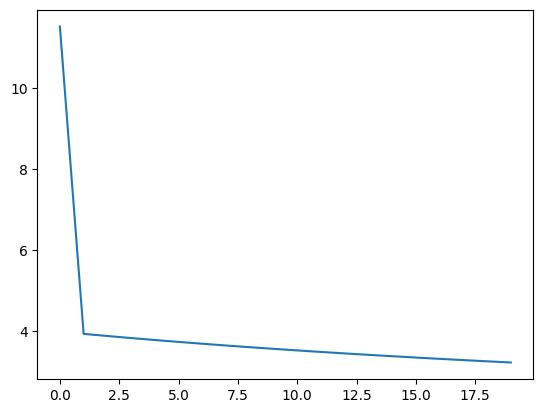

In [20]:
import matplotlib.pyplot as plt
ToBeTrained = True
if ToBeTrained:
    avg_loss = []
    forward_time = []
    backward_time = []
    numEpochs = 20
    bs = 1
    lr = 0.001
    loop = tqdm(range(numEpochs))
    for i in loop:
        c0 = train_images[0].reshape(1,1,28,28).astype(np.float32)
        
        # Forward
        sfts = time.time() # slow forward time start
        c1s,mask1s = Slow_ReLU_Conv(c0.astype(np.float32),k1,bc1,pad=0,stride=2)
        c2s,mask2s = Slow_ReLU_Conv(c1s.astype(np.float32),k2,bc2,pad=1,stride=2)
        c3s,mask3s = Slow_ReLU_Conv(c2s.astype(np.float32),k3,bc3,pad=0,stride=2)

        imlps = c3s.reshape(1,-1)
        fl,fa,sl,sa = ReLU_SoftMax_FullyConnected(imlps,w1,b1,w2,b2)
        sfte = time.time() # slow forward time end
        sft = sfte - sfts
        forward_time.append(sft)
        
        # Loss
        loss = crossEntropy(sa,train_labels[0])
        avg_loss.append(loss)

        # Backward
        sbts = time.time() # slow backward time start
        dL_i_mlp,dL_dw1,dL_db1,dL_dw2,dL_db2 = ReLU_SoftMax_FC_Backward(bs,sa,train_labels[0],w1,w2,fa,fl,imlps)
        dL_i_mlp = dL_i_mlp.reshape(c3s.shape)

        gi3,gk3,gb3 = Slow_ReLU_Gradient(c2s,dL_i_mlp,k3,mask3s,pad=0,stride=2)

        gi2,gk2,gb2 = Slow_ReLU_Gradient(c1s,gi3,k2,mask2s,pad=1,stride=2)
        gi1,gk1,gb1 = Slow_ReLU_Gradient(c0,gi2,k1,mask1s,pad=0,stride=2)
        sbte = time.time() # slow backward time end
        sbt = sbte - sbts
        backward_time.append(sbt)

        # Weights update
        w1 -= lr*dL_dw1
        b1 -= lr*dL_db1
        w2 -= lr*dL_dw2
        b2 -= lr*dL_db2
        k3 -= lr*gk3
        k2 -= lr*gk2
        k1 -= lr*gk1
        bc3 -= lr*gb3.reshape(-1)
        bc2 -= lr*gb2.reshape(-1)
        bc1 -= lr*gb1.reshape(-1)
        
        if len(avg_loss) >= 2:
            loop.set_postfix(pendence=f" {avg_loss[i]-avg_loss[i-1]}",avgForward=f"{avgList(forward_time)} s", avgBackward=f"{avgList(backward_time)} s" )

    plt.plot(avg_loss)
    plt.show()
# 2.64135 <-> 2.64095
# 2.64055 <-> 2.64020
# 2.64015 <-> 2.63980
# 2.63910 <-> 2.63840

These are the results for 20 epochs of one image:
- average forward time : 3.6265 s
- average backward time : 9.8262 s

Plot of the loss:

<img src="IMAGES\Slow Approach.png">


### Test for Fast approach

In this panel the approach is tested to see if it learns or not. the test uses first just one image, then the first 100 for each eopch, in order to see if the loss descends during the training

#### Weights Initialization

In [21]:
k1 = np.random.rand(int(numpy_weights['k1'].flatten().shape[0])).reshape(numpy_weights['k1'].shape)
bc1 = np.random.rand(int(numpy_weights['b_conv1'].flatten().shape[0])).reshape(numpy_weights['b_conv1'].shape)
k2 = np.random.rand(int(numpy_weights['k2'].flatten().shape[0])).reshape(numpy_weights['k2'].shape)
bc2 = np.random.rand(int(numpy_weights['b_conv2'].flatten().shape[0])).reshape(numpy_weights['b_conv2'].shape)
k3 = np.random.rand(int(numpy_weights['k3'].flatten().shape[0])).reshape(numpy_weights['k3'].shape)
bc3 = np.random.rand(int(numpy_weights['b_conv3'].flatten().shape[0])).reshape(numpy_weights['b_conv3'].shape)
w1 = np.random.rand(int(numpy_weights['w1'].flatten().shape[0])).reshape(numpy_weights['w1'].shape)
b1 = np.random.rand(int(numpy_weights['b1'].flatten().shape[0])).reshape(numpy_weights['b1'].shape)
w2 = np.random.rand(int(numpy_weights['w2'].flatten().shape[0])).reshape(numpy_weights['w2'].shape)
b2 = np.random.rand(int(numpy_weights['b2'].flatten().shape[0])).reshape(numpy_weights['b2'].shape)

In [22]:
def avgList(listA):
    sum_li = sum(listA)
    length_li = len(listA)
    return round(sum_li/length_li,4)

#### Same Image

### Training the "Fast" NumPy CNN (Single Image Test)

This tests training using the Im2Col-based `im2col_convolution` and the revised `Fast_ReLU_Gradient` (from cell `c808bdb6`) on a single image.

**Per-Epoch Steps (differences from "Slow" are conv/grad functions):**
1.  **Forward Pass:**
    *   `c0 -> im2col_convolution (k1,bc1,p=0,s=2) -> c1s`
    *   `c1s -> im2col_convolution (k2,bc2,p=1,s=2) -> c2s`
    *   `c2s -> im2col_convolution (k3,bc3,p=0,s=2) -> c3s`
    *   `c3s -> flatten -> imlps -> ReLU_SoftMax_FullyConnected -> sa`
2.  **Loss:** `loss = crossEntropy(sa, true_label)`
3.  **Backward Pass:** `ReLU_SoftMax_FC_Backward` for MLP, then `Fast_ReLU_Gradient` (using `sliding_window_view` for `gi` and `gk`) for conv layers.
4.  **Weight Update:** Standard gradient descent.

The loss is plotted. Consistent padding/stride ensures correct feature dimensions for the MLP. This setup tests the learning capability and performance of the more optimized NumPy convolution functions.

100%|██████████| 20/20 [00:00<00:00, 112.21it/s, avgBackward=0.0025 s, avgForward=0.0008 s, pendence=[-0.01787574]]


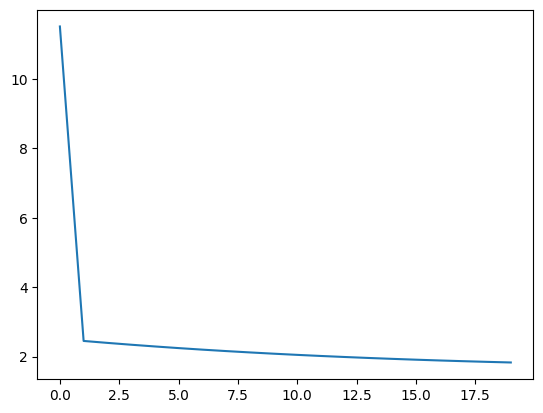

In [ ]:
import matplotlib.pyplot as plt
avg_loss = []
forward_time = []
backward_time = []
numEpochs = 20
bs = 1
lr = 0.001
loop = tqdm(range(numEpochs))
for i in loop:
    c0 = train_images[0].reshape(1,1,28,28).astype(np.float32)
    
    # Forward
    sfts = time.time() # slow forward time start
    c1s,mask1s = im2col_convolution(c0.astype(np.float32),k1,bc1,pad=0,stride=2)
    c2s,mask2s = im2col_convolution(c1s.astype(np.float32),k2,bc2,pad=1,stride=2)
    c3s,mask3s = im2col_convolution(c2s.astype(np.float32),k3,bc3,pad=0,stride=2)
    imlps = c3s.reshape(1,-1)
    fl,fa,sl,sa = ReLU_SoftMax_FullyConnected(imlps,w1,b1,w2,b2)
    sfte = time.time() # slow forward time end
    sft = sfte - sfts
    forward_time.append(sft)
    
    # Loss
    loss = crossEntropy(sa,train_labels[0])
    avg_loss.append(loss)

    # Backward
    sbts = time.time() # slow backward time start
    dL_i_mlp,dL_dw1,dL_db1,dL_dw2,dL_db2 = ReLU_SoftMax_FC_Backward(bs,sa,train_labels[0],w1,w2,fa,fl,imlps)
    dL_i_mlp = dL_i_mlp.reshape(c3s.shape)

    gi3,gk3,gb3 = Fast_ReLU_Gradient(c2s,dL_i_mlp,k3,mask3s,pad=0,stride=2)
    gi2,gk2,gb2 = Fast_ReLU_Gradient(c1s,gi3,k2,mask2s,pad=1,stride=2)
    gi1,gk1,gb1 = Fast_ReLU_Gradient(c0,gi2,k1,mask1s,pad=0,stride=2)
    sbte = time.time() # slow backward time end
    sbt = sbte - sbts
    backward_time.append(sbt)

    # Weights update
    w1 -= lr*dL_dw1
    b1 -= lr*dL_db1
    w2 -= lr*dL_dw2
    b2 -= lr*dL_db2
    k3 -= lr*gk3
    k2 -= lr*gk2
    k1 -= lr*gk1
    bc3 -= lr*gb3
    bc2 -= lr*gb2
    bc1 -= lr*gb1
    
    if len(avg_loss) > 2:
        loop.set_postfix(pendence=f" {avg_loss[i]-avg_loss[i-1]}",avgForward=f"{avgList(forward_time)} s", avgBackward=f"{avgList(backward_time)} s" )

plt.plot(avg_loss)
plt.show()

These are the results for 20 epochs of one image:
- average forward time : 0.0022 s
- average backward time : 0.0097 s

Plot of the loss:

<img src="IMAGES\Fast Approach.png">
